In [1]:
import torch
import os
from typing import List
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import albumentations as A
import numpy as np
import albumentations.pytorch as al_pytorch
from typing import Dict, Tuple
torch.__version__

'1.11.0+cpu'

## Number of images

In [2]:
DATA_ROOT_PATH:str = "/kaggle/input/anime-sketch-colorization-pair/data/"
#
train_path:str = f"{DATA_ROOT_PATH}train/"
train_images:List[str] = [ f"{train_path}{x}" for x in os.listdir(train_path) ]
test_path:str = f"{DATA_ROOT_PATH}val/"
test_images:List[str] = [ f"{test_path}{x}" for x in os.listdir(test_path) ]
#
print(" Nb of train images : " + str(len(train_images)))
print(" Nb of test images : " + str(len(test_images)))

 Nb of train images : 14224
 Nb of test images : 3545


## Let's plot a few images

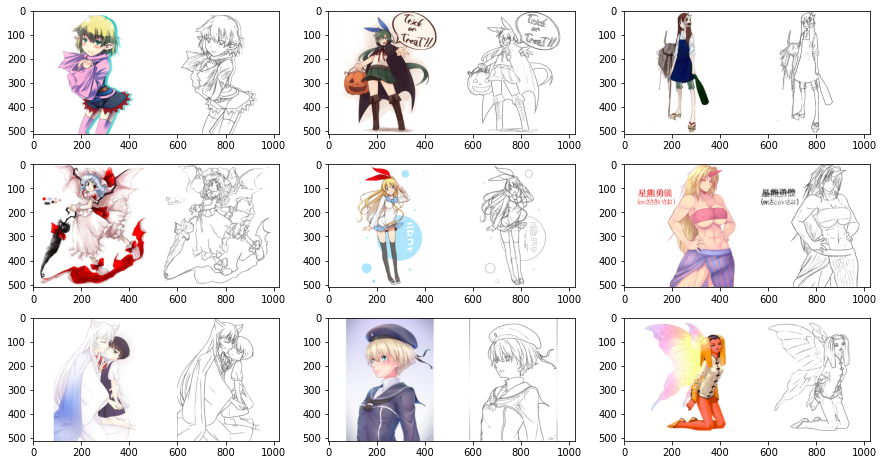

In [3]:
plt.figure(figsize=(15,8))
for i, img_path in enumerate(train_images[:9]):
    im = Image.open(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(im)

## DataSet

In [4]:
class AnimeDataset(torch.utils.data.Dataset):
    """ Sketchs and Colored Image dataset """
    
    def __init__(self,imgs_path:List[str],transforms:transforms.Compose)->None:
        """ Set the transforms and file path """
        self.list_files = imgs_path
        self.transform = transforms
        
    def __len__(self) -> int:
        """ Should return number of files """
        return len(self.list_files)
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Get image and mask by index """
        # read image file
        img_path = img_file = self.list_files[index]
        image = np.array(Image.open(img_path))
        
        # divide image into sketchs and colored_imgs, right is sketch and left is colored images
        # as according to the dataset
        sketchs = image[:,image.shape[1]//2:,:]
        colored_imgs = image[:,:image.shape[1]//2,:]
        
        # data augmentation on both sketchs and colored_imgs
        augmentations = self.transform.both_transform(image=sketchs, image0=colored_imgs)
        sketchs, colored_imgs = augmentations['image'], augmentations['image0']
        
        # conduct data augmentation respectively
        sketchs = self.transform.transform_only_input(image=sketchs)['image']
        colored_imgs = self.transform.transform_only_mask(image=colored_imgs)['image']
        return sketchs, colored_imgs
    
    
class Transforms:
    """ Class to hold transforms """
    def __init__(self):
        # use on both sketchs and colored images
        self.both_transform = A.Compose([
            A.Resize(width=1024, height=1024),
            A.HorizontalFlip(p=.5)
        ],
            additional_targets={'image0':'image'}
        )
        
        # use on sketchs only
        self.transform_only_input = A.Compose([
            # A.ColorJitter(p=.1),
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            al_pytorch.ToTensorV2(),
        ])
        
        # use on colored images
        self.transform_only_mask = A.Compose([
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            al_pytorch.ToTensorV2(),
        ])

Create the dataset

In [5]:
train_dataset = AnimeDataset(
    imgs_path=train_images, 
    transforms=Transforms()
)
test_dataset = AnimeDataset(
    imgs_path=test_images, 
    transforms=Transforms()
)
len(train_dataset), len(test_dataset)

(14224, 3545)

## Dataloader

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

Try out a simple image from the batch

In [7]:
train_imgs_batch, train_masks_batch = next(iter(train_dataloader))
print("The shape of the train loader is ", train_imgs_batch.shape)
test_imgs_batch, test_masks_batch = next(iter(test_dataloader))
print("The shape of the test loader is ", test_imgs_batch.shape)

The shape of the train loader is  torch.Size([4, 3, 1024, 1024])
The shape of the test loader is  torch.Size([1, 3, 1024, 1024])


Plot the image and sketch

1. Image

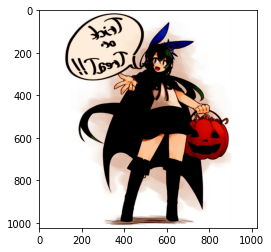

In [8]:
plt.imshow(train_masks_batch[1].permute(1, 2, 0).detach().numpy())

Sketch

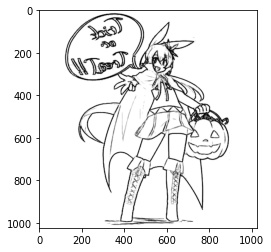

In [9]:
plt.imshow(train_imgs_batch[1].permute(1, 2, 0).detach().numpy())